In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from tsforest.forecaster import LightGBMForecaster

import matplotlib.pyplot as plt
import seaborn as sns

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .dropna()
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [ ]:
weights_level12 = pd.read_parquet("../input/weights_level12.parquet")
weights_level12.head()                         

In [ ]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["store_id","item_id"]).rename({"q":"s"}, axis=1)
scales.head()

In [ ]:
weights = (weights_level12
    .merge(scales, how="inner", on=["store_id","item_id"])
    .assign(weight = lambda x: x.weight/x.s)
    .assign(weight = lambda x: x.weight/x.weight.median())
    .drop(["s"], axis=1)
)
weights.head()

In [ ]:
#data = pd.merge(data, weights, how="left", on=["store_id","item_id"])
#data.head()

In [ ]:
#weights.weight.describe()

***

In [ ]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

In [ ]:
#valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13)
#valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-06-19")), ]
valid_periods = [(pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")), ]
valid_periods

***
### adds time series stats features

In [ ]:
def compute_ts_stats(data, ts_uid_columns, valid_index=None, period={"days":365}):
    if valid_index is not None:
        data = data.drop(valid_index, axis=0)
    end_date = data.ds.max()
    start_date = end_date - pd.DateOffset(**period)
    result = (data
              .query("@start_date <= ds <= @end_date")
              .groupby(ts_uid_columns)
              .agg(mean_q=("y", np.mean))
              .reset_index()
              )
    return result

#ts_stats = compute_ts_stats(data, ["item_id","store_id"], valid_index, period={"days":365})
#data = pd.merge(data, ts_stats, how="left", on=["item_id", "store_id"])

***
## training

In [11]:
model_params = {
    'objective':'poisson',
    'metric':'None',
    'num_iterations':10000,
    'early_stopping_rounds':200,
    'max_bin': 255,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 127, 
    'learning_rate': 0.075, 
    #'min_data_in_leaf': 50,
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    'bagging_fraction':0.75,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':19
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    #"week_day",
    "month_progress",
    "week_day_cos",
    "week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":["sell_price",
                        "regular_price",
                        #"ts_id",
                        "event_type_1",
                        "event_name_2",
                        "event_type_2"],
    "categorical_features":{"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id","store_id"]
}

***
### Training validation models

In [12]:
# 3 years of history
train_history = 1095

############################################### 1/1 ################################################
##### Validation period: (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 0.987511
[50]	valid_0's wrmsse: 0.9103
[75]	valid_0's wrmsse: 0.893402
[100]	valid_0's wrmsse: 0.887986
[125]	valid_0's wrmsse: 0.884612
[150]	valid_0's wrmsse: 0.882751
[175]	valid_0's wrmsse: 0.881097
[200]	valid_0's wrmsse: 0.880626
[225]	valid_0's wrmsse: 0.880055
[250]	valid_0's wrmsse: 0.879759
[275]	valid_0's wrmsse: 0.879483
[300]	valid_0's wrmsse: 0.879306
[325]	valid_0's wrmsse: 0.879029
[350]	valid_0's wrmsse: 0.878971
[375]	valid_0's wrmsse: 0.878922
[400]	valid_0's wrmsse: 0.879043
[425]	valid_0's wrmsse: 0.878965
[450]	valid_0's wrmsse: 0.878766
[475]	valid_0's wrmsse: 0.878819
[500]	valid_0

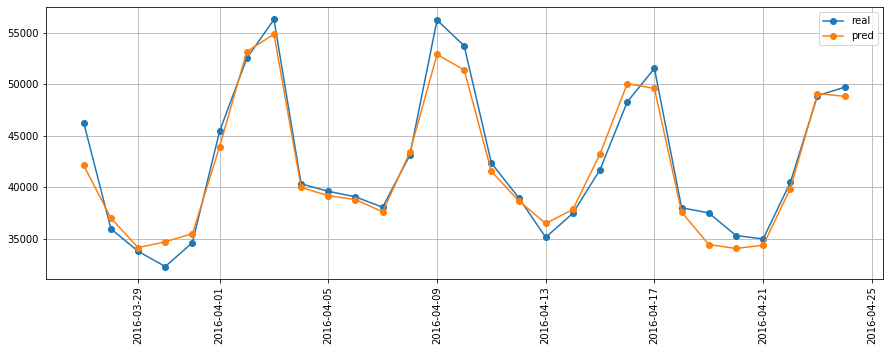

In [13]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level12, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    #lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    #lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)
    
    # visualizing the predictions at level 1
    predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])
    mrg =  (data.loc[:, ["ds","item_id","store_id","y"]]
            .merge(predictions, how="inner", on=["ds","item_id","store_id"]))
    df = mrg.groupby(["ds"])["y","y_pred"].sum().reset_index()
    
    print("RMSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2"))))
    print("RMSSE:", np.sqrt(np.mean(df.eval("(y-y_pred)**2")))/5926.0127)
    
    plt.figure(figsize=(15,5))
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()

***
### final model

In [14]:
model_kwargs["model_params"]["num_iterations"] = best_iterations[0]
model_kwargs["model_params"]

{'objective': 'poisson',
 'metric': 'None',
 'num_iterations': 995,
 'early_stopping_rounds': 200,
 'max_bin': 255,
 'bin_construct_sample_cnt': 6000000,
 'num_leaves': 127,
 'learning_rate': 0.075,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.75,
 'bagging_freq': 1,
 'lambda_l2': 0.1,
 'seed': 19}

In [22]:
train_start = data.ds.max() - pd.DateOffset(days=train_history)
train_data = data.query("ds >= @train_start").reset_index(drop=True)

In [23]:
fcaster = LightGBMForecaster(**model_kwargs)
fcaster.prepare_features(train_data=train_data);
fcaster.train_features = reduce_mem_usage(fcaster.train_features)
fcaster.fit(fit_kwargs={"verbose_eval":20})

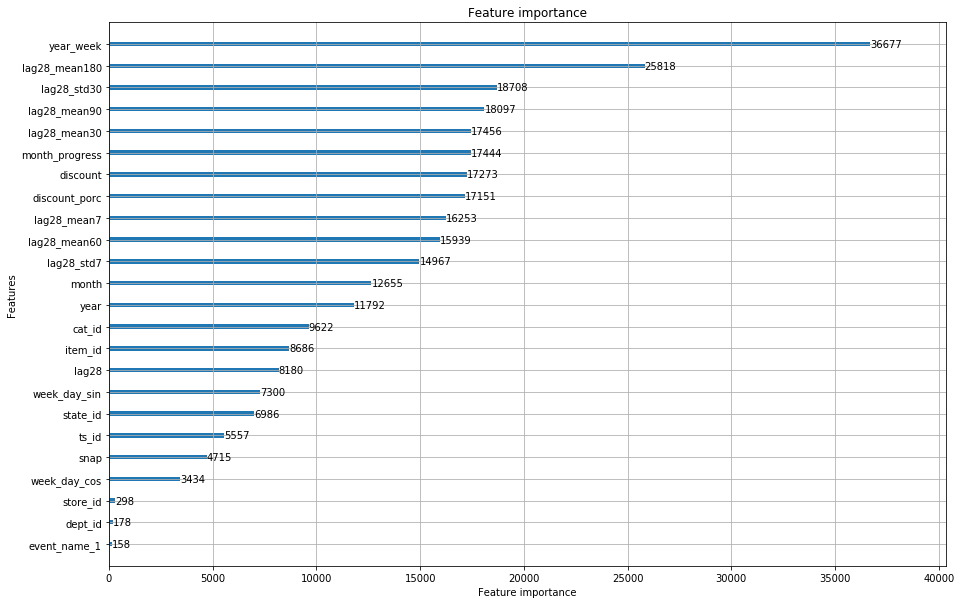

In [24]:
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));

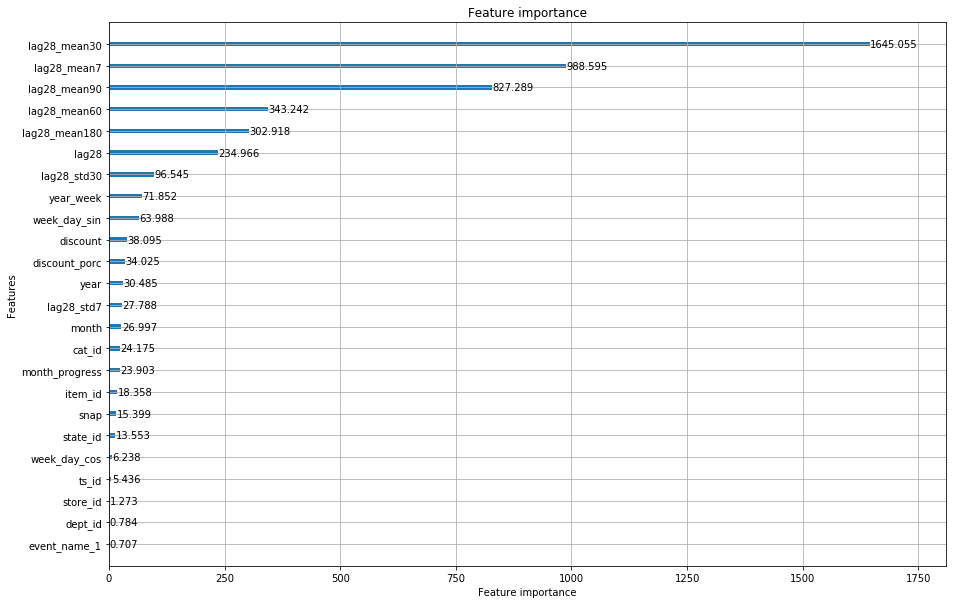

In [25]:
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***

In [62]:
predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])

In [63]:
predictions = pd.merge(predictions,
                       _fcaster.valid_features.loc[:, ["ds","item_id","store_id","y"]], 
                       how="inner", 
                       on=["ds","item_id","store_id"])

In [64]:
predictions["y_pred"] = 1.03*predictions.y_pred

In [65]:
np.sqrt(predictions
 .groupby(["ds"])[["y_pred", "y"]]
 .sum()
 .reset_index()
 .eval("(y_pred - y)**2")
 .mean()
)

1983.1279168848787

In [57]:
np.sqrt(predictions
 .groupby(["ds"])[["y_pred", "y"]]
 .sum()
 .reset_index()
 .eval("(y_pred - y)**2")
 .mean()
)

2681.940259239971

In [66]:
2681.940259239971/5926.012712033271

0.4525707907770876

In [67]:
1983.1279168848787/5926.012712033271

0.3346479350032391

***
## predicting

In [26]:
valid_dataframe = pd.read_parquet("../input/valid_dataframe.parquet")
eval_dataframe = pd.read_parquet("../input/eval_dataframe.parquet")
hierarchy = pd.read_parquet("../input/hierarchy.parquet")
submission = pd.read_csv("../input/sample_submission.csv")

In [27]:
valid_dataframe = pd.merge(valid_dataframe, weights, how="left")
eval_dataframe = pd.merge(eval_dataframe, weights, how="left")

In [28]:
#valid_dataframe = (valid_dataframe
#        .merge(scale, how="left", on=["store_id","item_id"])
#        .assign(lag28 = lambda x: x.lag28/x.s)
#        .drop("s", axis=1)
#       )

## updating rolling-window features
#valid_dataframe["lag28_mean7"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(7).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_mean30"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(30).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_mean60"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(60).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_mean90"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(90).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_mean180"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(180).mean().reset_index(0, drop=True)
#valid_dataframe["lag28_std7"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(7).std().reset_index(0, drop=True)
#valid_dataframe["lag28_std30"] = valid_dataframe.groupby("ts_id")["lag28"].rolling(30).std().reset_index(0, drop=True)

In [29]:
#eval_dataframe = (eval_dataframe
#        .merge(scale, how="left", on=["store_id","item_id"])
#        .assign(lag28 = lambda x: x.lag28/x.s)
#        .drop("s", axis=1)
#       )

# updating rolling-window features
#eval_dataframe["lag28_mean7"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(7).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_mean30"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(30).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_mean60"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(60).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_mean90"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(90).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_mean180"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(180).mean().reset_index(0, drop=True)
#eval_dataframe["lag28_std7"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(7).std().reset_index(0, drop=True)
#eval_dataframe["lag28_std30"] = eval_dataframe.groupby("ts_id")["lag28"].rolling(30).std().reset_index(0, drop=True)

***
### predictions for validation period

In [30]:
predictions_valid = pd.merge(fcaster.predict(valid_dataframe), 
                             hierarchy.loc[:, ["id", "item_id", "store_id"]], 
                             how="left")
predictions_valid["id"] = predictions_valid.id.map(lambda x: x+"_validation")

In [31]:
#predictions_valid = (
#    predictions_valid
#    .merge(scales, how="left", on=["store_id","item_id"])
#    .assign(y_pred = lambda x: x.y_pred*x.s)
#    .assign(lag28 = lambda x: x.lag28*)
#    .drop("s", axis=1)
#)

In [32]:
predictions_valid.y_pred.describe()

count    853720.000000
mean          1.483765
std           2.988723
min           0.047659
25%           0.364745
50%           0.711033
75%           1.458323
max         101.220349
Name: y_pred, dtype: float64

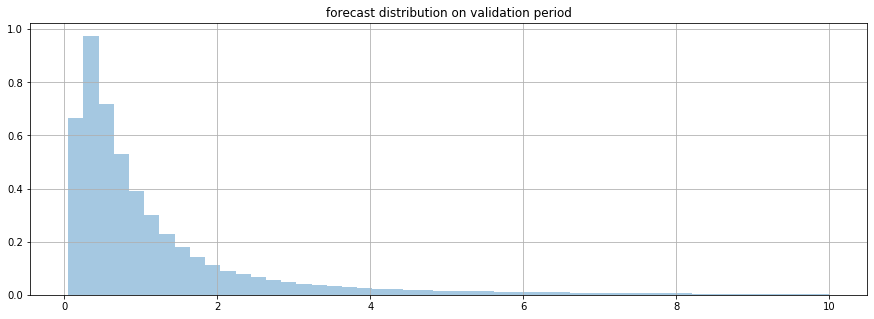

In [33]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_valid.query("y_pred < 10").y_pred.values, kde=False, norm_hist=True)
plt.title("forecast distribution on validation period")
plt.grid()

In [34]:
predictions_valid = (predictions_valid
                     .pivot(index="id", columns="ds", values="y_pred")
                     .reset_index()
                     )
predictions_valid.columns = ["id"] + [f"F{i}" for i in range (1,29)]

***
### predictions for evaluation period

In [35]:
#eval_dataframe = pd.merge(eval_dataframe, ts_stats, how="left")

In [36]:
predictions_eval = pd.merge(fcaster.predict(eval_dataframe), 
                            hierarchy.loc[:, ["id", "item_id", "store_id"]],
                            how="left")
predictions_eval["id"] = predictions_eval.id.map(lambda x: x+"_evaluation")

In [37]:
#predictions_eval = (
#    predictions_eval
#    .merge(scales, how="left", on=["store_id","item_id"])
#    .assign(y_pred = lambda x: x.y_pred*x.s)
#    .drop("s", axis=1)
#)

In [38]:
predictions_eval.y_pred.describe()

count    853720.000000
mean          0.592542
std           0.461016
min           0.102727
25%           0.314153
50%           0.478231
75%           0.720920
max           9.767442
Name: y_pred, dtype: float64

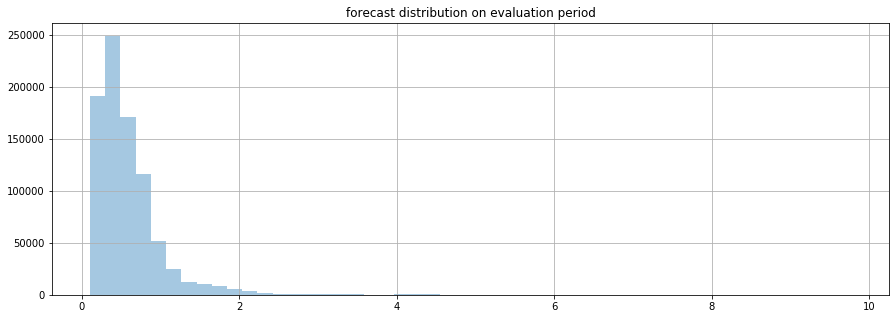

In [39]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_eval.query("y_pred < 10").y_pred.values, kde=False)
plt.title("forecast distribution on evaluation period")
plt.grid()

In [40]:
predictions_eval = (predictions_eval
                    .pivot(index="id", columns="ds", values="y_pred")
                    .reset_index()
                   )
predictions_eval.columns = ["id"] + [f"F{i}" for i in range (1,29)]

***
### submission file

In [41]:
predictions_all = pd.concat([predictions_valid, predictions_eval], ignore_index=True)

In [42]:
assert set(predictions_all.id) == set(submission.id), \
    "there are missing time series predictions."

In [43]:
submission = pd.merge(submission.loc[:, ["id"]], predictions_all)

In [44]:
file_path = "../output/lgbm_bottom_v31.csv.gz"

if os.path.isfile(file_path):
    print("File already exists.")
else:
    submission.to_csv(file_path, index=False, compression="gzip")

In [45]:
!ls ../output

lgbm_bottom_v1.csv.gz	lgbm_bottom_v2.csv.gz	lgbm_bottom_v3.csv.gz
lgbm_bottom_v10.csv.gz	lgbm_bottom_v20.csv.gz	lgbm_bottom_v30.csv.gz
lgbm_bottom_v11.csv.gz	lgbm_bottom_v21.csv.gz	lgbm_bottom_v31.csv.gz
lgbm_bottom_v12.csv.gz	lgbm_bottom_v22.csv.gz	lgbm_bottom_v4.csv.gz
lgbm_bottom_v13.csv.gz	lgbm_bottom_v23.csv.gz	lgbm_bottom_v5.csv.gz
lgbm_bottom_v14.csv.gz	lgbm_bottom_v24.csv.gz	lgbm_bottom_v6.csv.gz
lgbm_bottom_v15.csv.gz	lgbm_bottom_v25.csv.gz	lgbm_bottom_v7.csv.gz
lgbm_bottom_v16.csv.gz	lgbm_bottom_v26.csv.gz	lgbm_bottom_v8.csv.gz
lgbm_bottom_v17.csv.gz	lgbm_bottom_v27.csv.gz	lgbm_bottom_v9.csv.gz
lgbm_bottom_v18.csv.gz	lgbm_bottom_v28.csv.gz
lgbm_bottom_v19.csv.gz	lgbm_bottom_v29.csv.gz


In [46]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ../output/lgbm_bottom_v31.csv.gz -m ""

100%|██████████████████████████████████████| 13.6M/13.6M [00:03<00:00, 3.88MB/s]
Successfully submitted to M5 Forecasting - Accuracy

***

In [ ]:
submission